# Bayesian Linear Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt

In [2]:
sns.set_style('whitegrid')
%matplotlib inline

## Linear Regression

Linear regression is a standard quantitative tool in every statistician's toolbox. It provides a simple, easy-to-understand framework for expressing a linear relationship between dependent and independent variables and can be readily applied in many situations. A linear regression takes the form of:

$$ Y = X\beta + \epsilon $$

Where $Y$ is the dependent variable, $X$ is our independent variable, $\beta$ are the coefficients for each feature in $X$, and $\epsilon$ is our error, assumed to be normally-distributed.

There are several ways to fit the coefficients. We typically use either Ordinary Least Squares (OLe eS) or Maximum Likelihood Estimation (MLE).

## Probabilistic Regression

The purpose of this chapter is to define a Bayesian, probabilistic linear regression method for easy use in Python. To this end, we will be using PyMC3, but it is good to review the basic theory of what we are dealing with. To reformulate this basic linear regression with a Bayesian methodology, we say that:

$$ Y \sim \mathcal{N}(X\beta, \sigma^2) $$

With Bayesian inference, a key component is that we define the pieces of our model as probability distributions. This makes our dependent variable a probability distribution as well. In this case, we are assuming that $Y$ is normally-distributed. The mean of this distribution is our linear value $X\beta$, while the variance is $\sigma^2$ (the variance of our error from the original model).

## Advantages of the Bayesian Approach

At the core, both the frequentist and Bayesian approaches try to get at the same solution. They only differ in how they go about it. By incorporating Bayesian statistics into our methodology, we allow for the inclusion of prior distributions. Priors allow us to include how we think our parameters are related into our model. 

In addition, our $\beta$ values in a Bayesian approach are themselves complete posterior distributions instead of point estimates. A point estimate will have a confidence interval, but an entire probability distribution provides us with a much more robust understanding of the uncertainty associated with our regression parameters.

## Defining a Toy Example

Let's generate some simple data for use with our new approach. Toy examples are always a little boring, but it is important to understand the basic approach before we get into a real world problem.

In [16]:
N = 100
intercept = 1
slope = 2

x = np.linspace(0, 1, N)
true_line = intercept + slope*x
y = true_line + np.random.normal(0, 0.5, size=N)

data = dict(x=x, y=y)

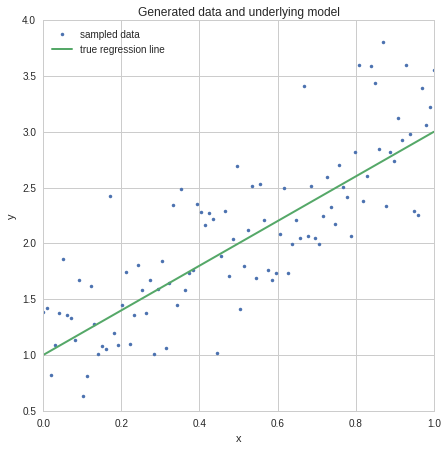

In [33]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, '.', label='sampled data')
ax.plot(x, true_line, label='true regression line', lw=2.)
plt.legend(loc=0);

The data points in this scatter plot are our observed information about the true relationship between $x$ and $y$. This observed information contorts our initial impressions of how our parameters are distributed into our posterior distributions.

## Creating Our Model

Let's define our priors for the Bayesian model. With PyMC3, it is remarkably easy to lay out which components of the model will follow which distributions, however, this may be confusing if you are unfamiliar with the Bayesian framework. The typical model definition is laid out here. In PyMC3, we define all of our variables using the `with` context.

In [34]:
with pm.Model() as model:
    # Defining priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.0)
    intercept = pm.Normal('Intercept', mu=0, sd=20)
    x_beta = pm.Normal('x', mu=0, sd=20)
    
    # Defining likelihood
    likelihood = pm.Normal('y', mu=(intercept + x_beta * x), sd=sigma, observed=y)
    
    # Running Inference
    start = pm.find_MAP() # Calculate a starting point
    step = pm.NUTS(scaling=start) # Define our sampling method
    trace = pm.sample(2000, step=step, start=start) # Draw 2000 samples!

Applied log-transform to sigma and added transformed sigma_log_ to model.
100%|██████████| 2000/2000 [00:02<00:00, 777.22it/s]


If you are less familiar with probabilistic programming, this may look like a lot of nonsense. The syntax for defining probability distributions is intuitive, but this is a lot of extra buzz around the implementation of a basic linear regression. 

For this reason, the PyMC3 developers introduced a `glm` module to simplify the definition of Generalized Linear Models (GLM), including linear regressions such as ours.

In [35]:
with pm.Model() as model:
    pm.glm.glm('y ~ x', data)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(2000, step=step, start=start)

Applied log-transform to sd and added transformed sd_log_ to model.
100%|██████████| 2000/2000 [00:01<00:00, 1326.54it/s]


## Basic Diagnostics

TRACE STUFF

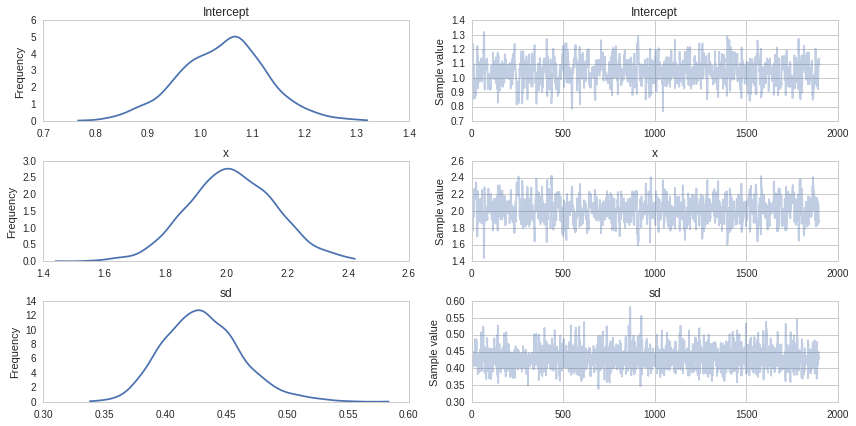

In [44]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

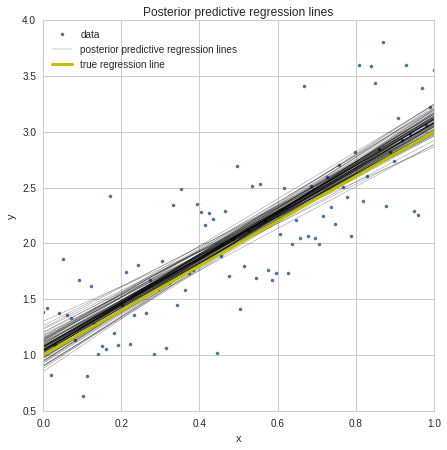

In [41]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, '.', label='data')
pm.glm.plot_posterior_predictive(trace, samples=100, 
                              label='posterior predictive regression lines')
plt.plot(x, true_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

## Handling Outliers

Let's make our data set a little weirder.

# Why Hierarchical Regression?

Hierarchical sounds super buzzword-y

There are many situations in real life that lend themselves to a hierarchical regression. 

# Cool, let's use real data

For our example of hierarchical regression, we are going to use a classic finance example, calculating historical market beta.

In [28]:
import datetime
import collections
import ystockquote as ysq

import pandas.io.data as web
import pandas as pd
import numpy as np

stocks = ['SPY', 'GOOG', 'TSLA', 'AAPL', 'AMZN']

start_date = "2012-09-01"
end_date = "2015-04-27"

close_prices = pd.DataFrame()

for stock in stocks:
    x = web.DataReader(stock, 'yahoo', start_date, end_date)['Close']
    x.name = stock
    close_prices[stock] = x
    
close_prices.head()

,SPY,GOOG,TSLA,AAPL,AMZN
Date,,,,,
2012-09-04,141.029999,681.041167,28.139999,674.970001,247.880005
2012-09-05,140.910004,680.721185,27.940001,670.230026,246.220001
2012-09-06,143.770004,699.401202,28.549999,676.270004,251.380005
2012-09-07,144.330002,706.151212,29.350000,680.439980,259.140015
2012-09-10,143.509995,700.771188,27.370001,662.739975,257.089996
